# EDA & Regression models: Delhi House Price Prediction

## Objective
The objective of this project is to analyse the Delhi housing market and deploy predictive models to estimate the regressor -"Price" based on key features like size, location and more.


## Workflow Overview :

1.   importing utilities

1.   loading and viewing the data

1.   analysing the dataset
2.   visualizing to get the basic overview of data


5.   Preprocessing


6. Feature selection




7.   Preparing the data for ML algorithms

8.   Training the data

9. Evaluating the models on test data

10. Visualizing the results

11. Meaningful insights




In [ ]:
# step-1 : importing utilities

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
import plotly.express as px

%matplotlib inline


In [ ]:
# step-2 : loading and viewing the data
df = pd.read_csv("Indian_housing_Delhi_data.csv")
df.head(2)

,house_type,house_size,location,city,latitude,longitude,price,currency,numBathrooms,numBalconies,isNegotiable,priceSqFt,verificationDate,description,SecurityDeposit,Status
0,1 RK Studio Apartment,400 sq ft,Kalkaji,Delhi,28.545561,77.254349,22000,INR,1.0,NaN,NaN,NaN,Posted a day ago,"Fully furnished, loaded with amenities & gadge...",No Deposit,Furnished
1,1 RK Studio Apartment,400 sq ft,Mansarover Garden,Delhi,28.643259,77.132828,20000,INR,1.0,NaN,NaN,NaN,Posted 9 days ago,Here is an excellent 1 BHK Independent Floor a...,No Deposit,Furnished


In [ ]:
df.shape

(5000, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   house_type        5000 non-null   object 
 1   house_size        5000 non-null   object 
 2   location          5000 non-null   object 
 3   city              5000 non-null   object 
 4   latitude          5000 non-null   float64
 5   longitude         5000 non-null   float64
 6   price             5000 non-null   int64  
 7   currency          5000 non-null   object 
 8   numBathrooms      4975 non-null   float64
 9   numBalconies      2737 non-null   float64
 10  isNegotiable      179 non-null    object 
 11  priceSqFt         0 non-null      float64
 12  verificationDate  5000 non-null   object 
 13  description       4715 non-null   object 
 14  SecurityDeposit   5000 non-null   object 
 15  Status            5000 non-null   object 
dtypes: float64(5), int64(1), object(10)
memory

In [ ]:
df.drop('priceSqFt', axis = 1, inplace = True)

In [ ]:
df.describe()

,latitude,longitude,price,numBathrooms,numBalconies
count,5000.000000,5000.000000,5.000000e+03,4975.000000,2737.000000
mean,28.578012,77.174499,2.221738e+05,2.918593,1.954330
std,0.190186,0.115636,2.739843e+05,1.087823,0.547219
min,20.011379,72.771332,3.000000e+03,1.000000,1.000000
25%,28.544489,77.138248,2.950000e+04,2.000000,2.000000
50%,28.569295,77.196472,1.250000e+05,3.000000,2.000000
75%,28.618687,77.228950,3.011020e+05,4.000000,2.000000
max,28.805466,80.361313,3.010101e+06,10.000000,8.000000


In [ ]:
df['house_size']=(df['house_size']
                  .str.replace('sq ft', '', regex = False)
                  .str.replace(',', '', regex = False)
                  .str.strip()
                  .astype(int))

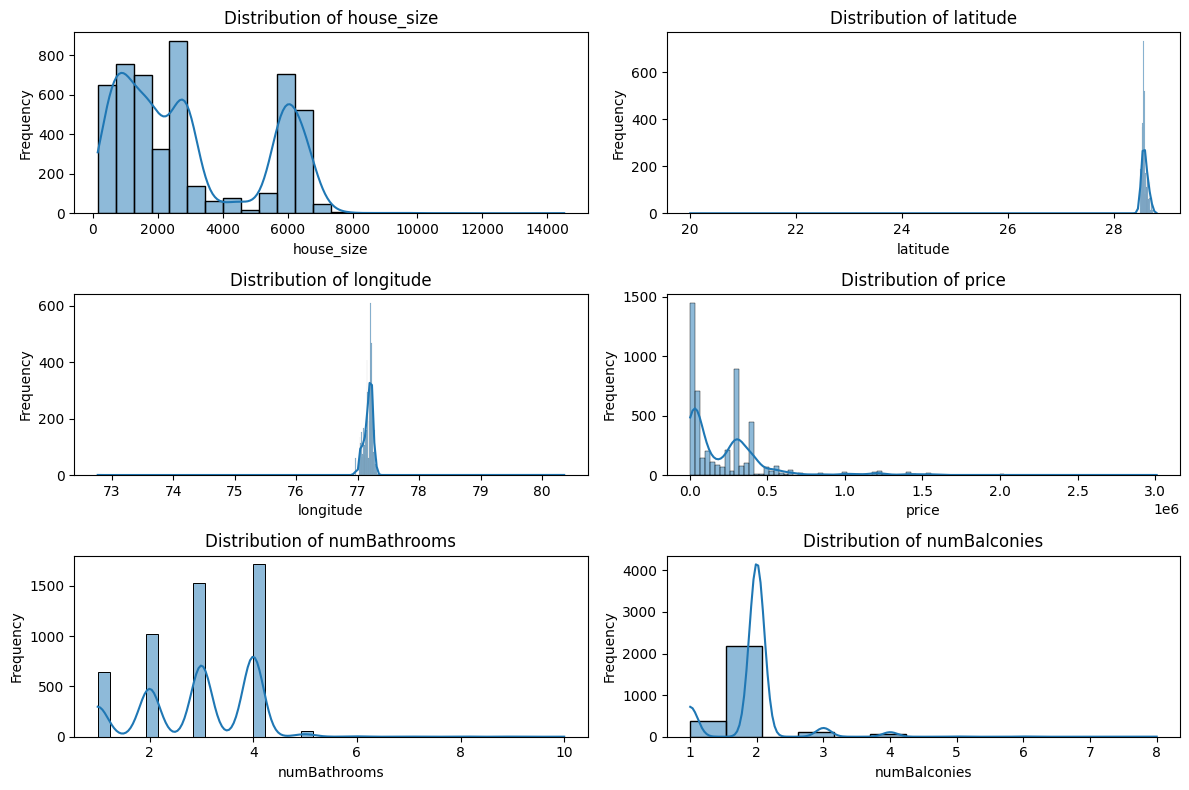

In [ ]:
num_columns = ['house_size','latitude', 'longitude', 'price', 'numBathrooms', 'numBalconies']


fig, axes = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns
axes = axes.flatten()  # Convert 2D array of axes into 1D for easy looping

for i, col in enumerate(num_columns):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()




*   house sizes plot has three peaks which shows most house sizes lies arounf 1000, 2400 and 6000 sq ft.

*   Latitude is concentrated about 28

*   Longitude is concenrated at 77 (which combined with latitude indicates that houses lies in the city of delhi)
*   Price(regressor) is highly right skewed.


*  number of bathrooms increases up to 4 along with the number of houses and then there's a drastic fall ie very few houses have more than 4 bathrooms.


*   Maximum number of houses have two balconies



In [ ]:
def classify_house_type(x):
    x = x.lower()
    if 'studio' in x: return 'Studio'
    if 'apartment' in x: return 'Apartment'
    if 'floor' in x: return 'Floor'
    if 'house' in x: return 'House'
    if 'villa' in x: return 'Villa'
    return 'Other'

In [ ]:
df['broad_type'] = df['house_type'].apply(classify_house_type)
type_counts = df['broad_type'].value_counts(normalize=True)*100

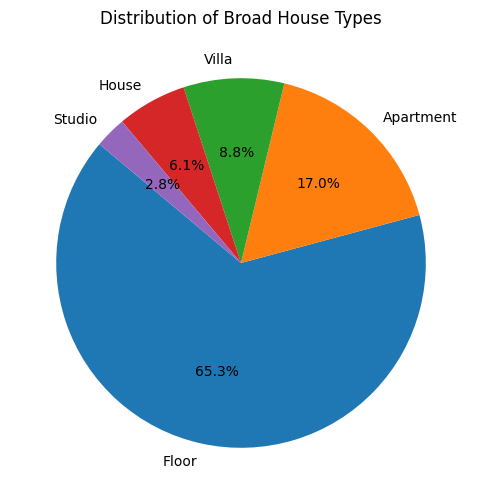

In [ ]:
plt.figure(figsize=(8,6))
type_counts.plot.pie(autopct='%1.1f%%', startangle=140, shadow = False)
plt.title('Distribution of Broad House Types')
plt.ylabel('')
plt.show()

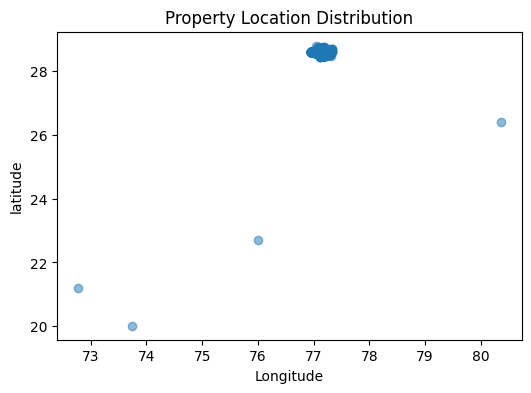

In [ ]:
plt.figure(figsize = (6,4))
plt.scatter(df['longitude'], df['latitude'], alpha = 0.5)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.title('Property Location Distribution')
plt.show()

Longitude and Latitude of New Delhi is 77.2192 and 28.6430 respectively. There are a few outliers in the plot that are noticable and can distort the analysis and lead to poor performance of the model. Removing them would help in understanding the visual clearly.

In Linear Regression, outliers may lead to overfitting and may yeild unstable coefficient.

In [ ]:
# Removing outliers
df = df[
    (df['latitude'] >= 28.5) & (df['latitude'] <= 28.7) &
    (df['longitude'] >= 77.0) & (df['longitude'] <= 77.3)
]

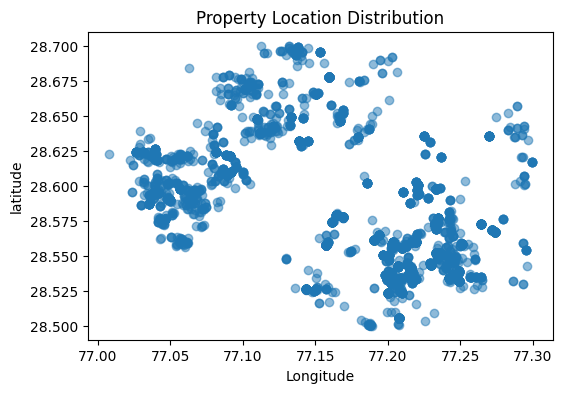

In [ ]:
plt.figure(figsize = (6,4))
plt.scatter(df['longitude'], df['latitude'], alpha = 0.5)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.title('Property Location Distribution')
plt.show()

From the plot, it is evident that areas of west delhi and south east delhi are densely populated(in terms of houses). Broadly, three clusters are visible.

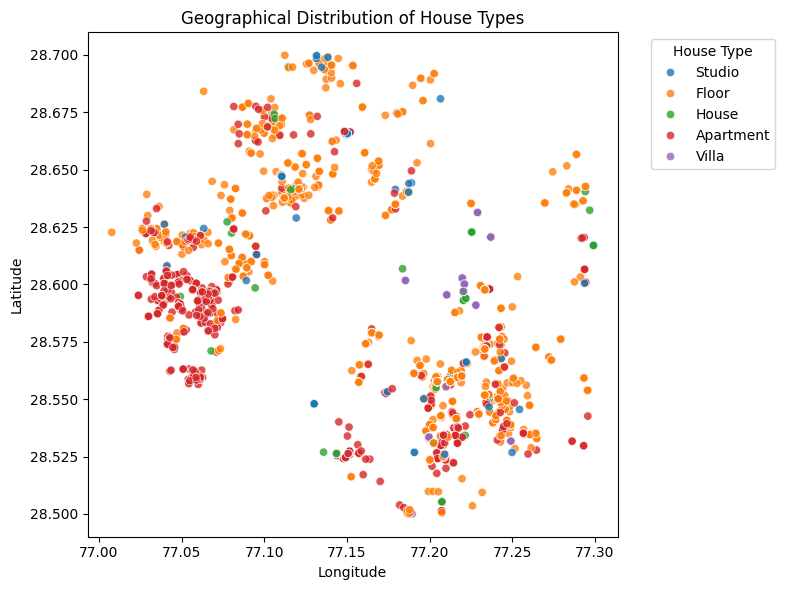

In [ ]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=df, x='longitude', y='latitude', hue='broad_type', alpha=0.8)

plt.title("Geographical Distribution of House Types")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='House Type')

plt.tight_layout()
plt.show()


West Delhi is densely populated with apartments and floors are widespread all over the regions of delhi. Houses and studios are comparatively very less in number. Villas can be noticed in the eastern region.

In [ ]:
fig = px.scatter_mapbox(
    df,
    lat="latitude",
    lon="longitude",
    color="price",  # or use 'house_type'
    size="price",   # optional: larger circles for higher price
    color_continuous_scale="Viridis",
    mapbox_style="carto-positron",
    zoom=10,
    height=600,
    title="House Prices Across Delhi"
)

fig.show()


In [ ]:
# Handling missing data(numeric only)
df.fillna(df.mean(numeric_only=True), inplace=True)

In [ ]:
# Converting the type of feature for better interpretability
df["numBathrooms"] = df['numBathrooms'].astype(int)

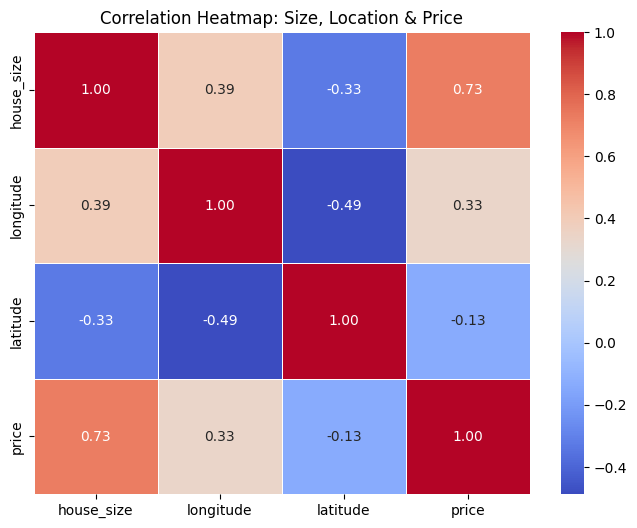

In [ ]:
features = ['house_size', 'longitude', 'latitude', 'price']
corr_matrix = df[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Size, Location & Price")
plt.show()




*   Correlation between house size and price is 0.73 which is positive and
indicates high correlation implying price increases as house price increases.



*   Longitude and price are moderately correlated, houses lying in the east region tends to a bit expensive. (also influenced because of the presence of villas)
*   latitude and price are negatively correlated which tells that price in the southern region are less.









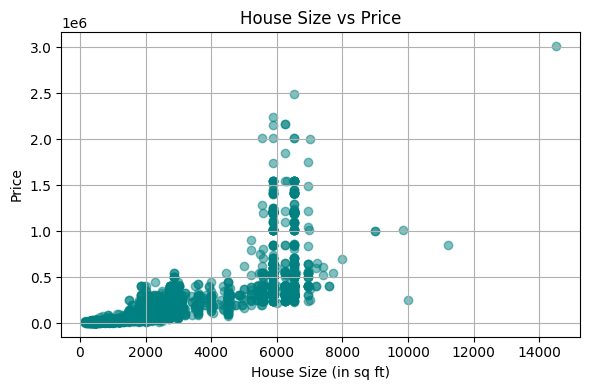

In [ ]:
plt.figure(figsize=(6, 4))

plt.scatter(df['house_size'], df['price'], alpha=0.5, color='teal')
plt.title("House Size vs Price")
plt.xlabel("House Size (in sq ft)")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df.drop(['numBalconies', 'house_type','location','city','currency', 'isNegotiable','verificationDate','description','SecurityDeposit'],axis =1, inplace = True)

In [ ]:
df.head(1)

,house_size,latitude,longitude,price,numBathrooms,Status,broad_type
0,400,28.545561,77.254349,22000,1,Furnished,Studio


In [ ]:
status_counts = df['Status'].value_counts(normalize=True) * 100
print(status_counts)

Status
Unfurnished       47.553381
Semi-Furnished    37.210854
Furnished         15.235765
Name: proportion, dtype: float64


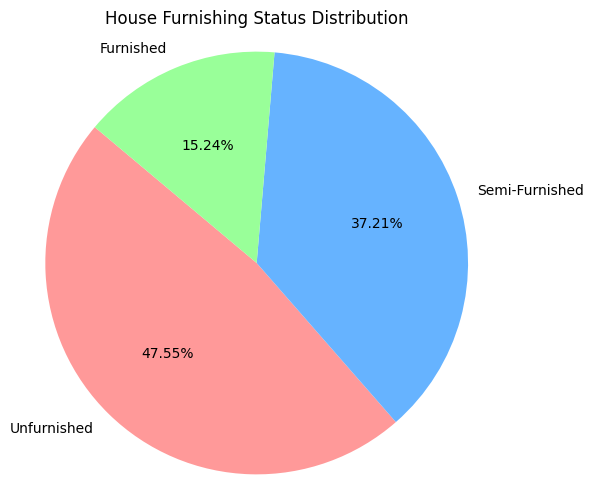

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct=lambda p: f'{p:.2f}%',
    startangle=140,
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
plt.title("House Furnishing Status Distribution")
plt.axis('equal')
plt.show()

Surprisingly only 15% houses are furnished.

###One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['Status', 'broad_type'], drop_first=True)

Preparing the data for Machine Learning algorithm by standardizing the data and separating the data for training and testing.

In [ ]:
X = df.drop('price', axis=1)
y = np.log1p(df['price'])  # log(1+price) to reduce skewness

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr = LinearRegression().fit(X_train_scaled, y_train)
ridge = Ridge(alpha=1.0).fit(X_train_scaled, y_train)
lasso = Lasso(alpha=0.1).fit(X_train_scaled, y_train)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42).fit(X_train, y_train)  # no scaling needed

In [ ]:
models = {'Linear': lr, 'Ridge': ridge, 'Lasso': lasso, 'XGBoost': xgb}

for name, model in models.items():
    preds = model.predict(X_test if name == 'XGBoost' else X_test_scaled)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name}: MSE = {mse:.2f}, R² = {r2:.2f}")

Linear: MSE = 0.29, R² = 0.85
Ridge: MSE = 0.29, R² = 0.85
Lasso: MSE = 0.31, R² = 0.83
XGBoost: MSE = 0.07, R² = 0.97




*   Linear and Ridge regression yields the same results and 85% variance in the price is explained.


*   A bit less variance in price is explained as compared to the above two models
*   XGBoost works the finest and yields the least error and 97% of the variance is explained





### Fine tuning the parameters

In [ ]:
alpha_range = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# Ridge Regression
ridge_cv = GridSearchCV(ridge, alpha_range, cv=10, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

print("Best alpha for Ridge:", ridge_cv.best_params_['alpha'])
print("Best R² score (Ridge):", ridge_cv.best_score_)

# Lasso Regression
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, alpha_range, cv=10, scoring='r2')
lasso_cv.fit(X_train_scaled, y_train)

print("Best alpha for Lasso:", lasso_cv.best_params_['alpha'])
print("Best R² score (Lasso):", lasso_cv.best_score_)

Best alpha for Ridge: 10
Best R² score (Ridge): 0.8398405555788822
Best alpha for Lasso: 0.001
Best R² score (Lasso): 0.839831563444147


Fine tuning the parameter is not yielding much better results, reason might be the non-linearity of variables.

# Predictiong the test set results

In [ ]:
y_pred_log = xgb.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

In [ ]:
comparison_df = pd.DataFrame({
    'Predicted Price (₹)': y_pred_actual,
    'Actual Price (₹)': y_test_actual
})

comparison_df.head(5)


,Predicted Price (₹),Actual Price (₹)
178,26867.822266,32000.0
1922,369807.875000,301012.0
574,146698.984375,375000.0
1544,44609.593750,30000.0
3956,48700.382812,40000.0


The predicted prices are quiet near to the actual prices.

#Visualising the test set results

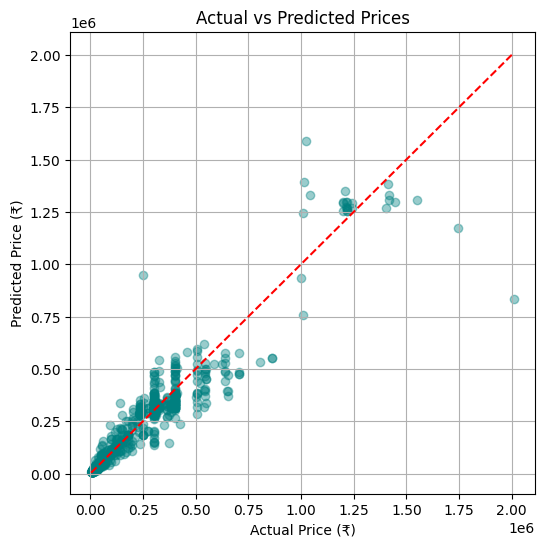

In [ ]:
# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.4, color='teal')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Price (₹)")
plt.ylabel("Predicted Price (₹)")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.show()

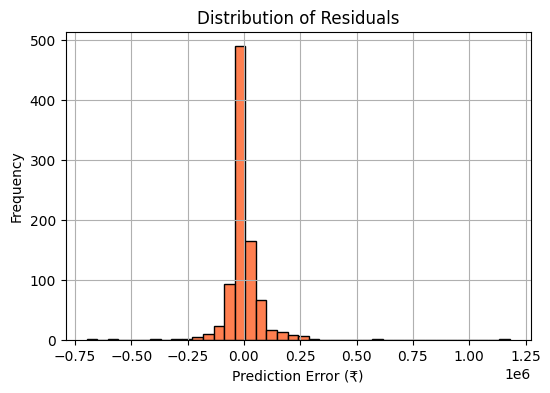

In [ ]:
# Residual Plot
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, color='coral', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error (₹)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The bar graph is taking the shape of gaussian distribution(bell shape)

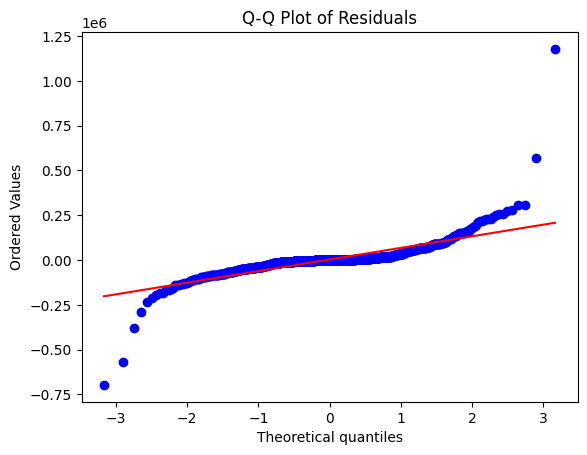

In [ ]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

This satisfies one of the OLS assumptions - normality of residuals

In [ ]:
# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Model Accuracy (100 - MAPE): {accuracy:.2f}%")


Mean Absolute Percentage Error (MAPE): 19.70%
Model Accuracy (100 - MAPE): 80.30%
